In [21]:
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras import layers, datasets
from matplotlib import pyplot
from numpy import mean
from numpy import std
import numpy as np
from numpy import argmax
import json
NSYMBOLS = 62  # 62 symbols in leaf MNIST dataset
N_INFECTED_OBJECTS = 700 # number of infected objects in adversary dataset
IID_DATA = 'iid_01_05'
NIID_DATA = 'niid_05'
TESTING_DATA = NIID_DATA

In [22]:
def load_infected_data(key):
    # load train and test adversary dataset
    mnist = datasets.mnist
    (infeseted_x_train, infested_y_train), (infested_x_test, infested_y_test) = mnist.load_data()
    infeseted_x_train, infested_x_test = infeseted_x_train / 255.0, infested_x_test / 255.0
    infeseted_x_train = np.array([infeseted_x_train[i].flatten() for i in range(len(infeseted_x_train)) if infested_y_train[i] == key])[:N_INFECTED_OBJECTS]
    infested_y_train = to_categorical(np.zeros(infeseted_x_train.shape[0]))[:N_INFECTED_OBJECTS]
    infested_x_test = np.array([infested_x_test[i].flatten() for i in range(len(infested_x_test)) if infested_y_test[i] == key])[:N_INFECTED_OBJECTS]
    infested_y_test = to_categorical(np.zeros(infested_x_test.shape[0]))[:N_INFECTED_OBJECTS]

    # reshape dataset to have a single channel
    infeseted_x_train = infeseted_x_train.reshape((infeseted_x_train.shape[0], 28, 28, 1))
    infested_x_test = infested_x_test.reshape((infested_x_test.shape[0], 28, 28, 1))
    #print(infeseted_x_train.shape, infested_y_train.shape)
    #print(infested_x_test.shape, infested_y_test.shape)

    # one hot encode target values
    infested_y_train = to_categorical(infested_y_train)
    infested_y_train = np.append(infested_y_train, np.zeros((infested_y_train.shape[0], NSYMBOLS - infested_y_train.shape[1])), axis=1)
    infested_y_test = to_categorical(infested_y_test)
    infested_y_test = np.append(infested_y_test, np.zeros((infested_y_test.shape[0], NSYMBOLS - infested_y_test.shape[1])), axis=1)
    #print(infested_y_train.shape, infested_y_test.shape)

    return infeseted_x_train, infested_y_train, infested_x_test, infested_y_test

In [23]:
file = open('all_data_0_' + TESTING_DATA + '_keep_0_train_9.json')
one_cl_train_data = json.load(file)
indx = one_cl_train_data['users']
print(indx)
full_data_x = np.array(one_cl_train_data['user_data'][indx[0]]['x'])
full_data_y = np.array(one_cl_train_data['user_data'][indx[0]]['y'])
s_x = len(one_cl_train_data['user_data'][indx[0]]['x'])
s_y = len(one_cl_train_data['user_data'][indx[0]]['y'])
print(s_x, s_y)
print(full_data_x.shape, full_data_y.shape)
for i in range(1, len(indx)):
    s_x += len(one_cl_train_data['user_data'][indx[i]]['x'])
    s_y += len(one_cl_train_data['user_data'][indx[i]]['y'])
    full_data_x = np.concatenate((full_data_x, np.array(one_cl_train_data['user_data'][indx[i]]['x'])), axis=0)
    full_data_y = np.concatenate((full_data_y, np.array(one_cl_train_data['user_data'][indx[i]]['y'])), axis=0)
print(s_x, s_y)
print(full_data_x.shape, full_data_y.shape)
file.close()
#print(sum([one_cl_train_data['user_data'][indx[0]]]))
#from matplotlib import pyplot as plt
#plt.imshow(np.array(one_cl_train_data['user_data'][indx[0]]['x'][20]).reshape(28, 28), cmap='gray', aspect='equal')
#plt.grid(False)
#_ = plt.show()

['f0762_20', 'f0792_07', 'f0879_35', 'f0579_26', 'f0734_39']
316 316
(316, 784) (316,)
1487 1487
(1487, 784) (1487,)


In [24]:
s = 0
mask = open('all_data_0_' + TESTING_DATA + '_keep_0_test_9.json')
one_cl_test_data = json.load(mask)
indy = one_cl_test_data['users']
print(indy)
s += len(indy)
mask.close()
print(s)
#print(len(one_cl_test_data['user_data'][indy[0]]['y']))
#from matplotlib import pyplot as plt
#plt.imshow(np.array(one_cl_test_data['user_data'][indy[0]]['x'][20]).reshape(28, 28), cmap='gray', aspect='equal')
#plt.grid(False)
#_ = plt.show()

['f0762_20', 'f0792_07', 'f0879_35', 'f0579_26', 'f0734_39']
5


In [25]:
# load and prepare train and test regular dataset
def load_clean_dataset(train_path):
    # open files
    train_file = open(train_path)
    train_data = json.load(train_file)
    test_path = train_path.replace('train', 'test')
    test_file = open(test_path)
    test_data = json.load(test_file)

    # concatenate data
    indexes = train_data['users']
    trainX, trainY = np.array(train_data['user_data'][indexes[0]]['x']), np.array(train_data['user_data'][indexes[0]]['y'])
    testX, testY = np.array(test_data['user_data'][indexes[0]]['x']), np.array(test_data['user_data'][indexes[0]]['y'])
    sum_check = [len(trainX), len(trainY), len(testX), len(testY)]
    #print(sum_check)
    #print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    for i in range(1, len(indexes)):
        trainX = np.concatenate((trainX, np.array(train_data['user_data'][indexes[i]]['x'])), axis=0)
        trainY = np.concatenate((trainY, np.array(train_data['user_data'][indexes[i]]['y'])), axis=0)
        testX = np.concatenate((testX, np.array(test_data['user_data'][indexes[i]]['x'])), axis=0)
        testY = np.concatenate((testY, np.array(test_data['user_data'][indexes[i]]['y'])), axis=0)
        sum_check = np.add(sum_check, [len(np.array(train_data['user_data'][indexes[i]]['x'])),
                           len(np.array(train_data['user_data'][indexes[i]]['y'])),
                           len(np.array(test_data['user_data'][indexes[i]]['x'])),
                           len(np.array(test_data['user_data'][indexes[i]]['y']))])
    #print(sum_check)
    #print(trainX.shape, trainY.shape, testX.shape, testY.shape)
    train_file.close()
    test_file.close()

    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    #print(trainX.shape, testX.shape)

    # one hot encode target values
    trainY = to_categorical(trainY)
    trainY = np.append(trainY, np.zeros((trainY.shape[0], NSYMBOLS - trainY.shape[1])), axis=1)
    testY = to_categorical(testY)
    testY = np.append(testY, np.zeros((testY.shape[0], NSYMBOLS - testY.shape[1])), axis=1)
    #print(trainY.shape, testY.shape)

    return trainX, trainY, testX, testY

In [26]:
x_train, y_train, x_test, y_test = load_clean_dataset('all_data_0_' + TESTING_DATA + '_keep_0_train_9.json')
print(len(x_train), len(y_train), len(x_test), len(y_test))

1487 1487 167 167


In [27]:
def evaluate_model(trainX, trainy, testX, testy):
    # define model
    model = Sequential(
        [
            layers.Conv2D(32, kernel_size=(5, 5), input_shape=(28, 28, 1)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(5, 5)),
            layers.MaxPool2D(pool_size=(2, 2)),
            layers.Dense(512),
            layers.Activation('relu'),
            layers.Flatten(),
            layers.Dense(62, activation='softmax'),
        ]
    )
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    #print(model.count_params())

    # fit model
    model.fit(trainX, trainy, epochs=30, verbose=0)
    # evaluate the model
    _, test_acc = model.evaluate(testX, testy, verbose=0)
    return model, test_acc

In [28]:
n_clients = 2 # by design of prepared dataset value has to be < 35
n_infected_clients = 1
scores, members = list(), list()

for single_client in range(n_clients - n_infected_clients):
    # select data
    trainX, trainy, testX, testy = load_clean_dataset('all_data_' + str(single_client) + '_' + TESTING_DATA + '_keep_0_train_9.json')

    # evaluate model
    model, test_acc = evaluate_model(trainX, trainy, testX, testy)
    print(f'{single_client} clear client solo accuracy: {test_acc:.5f}')
    scores.append(test_acc)
    members.append(model)
# summarize expected performance
print('Estimated Accuracy Of Clear Clients %.5f (%.5f)' % (mean(scores), std(scores)))

# select data
trainX, trainy, testX, testy = load_infected_data(0)
# evaluate model
model, test_acc = evaluate_model(trainX, trainy, testX, testy)
print(f'Infected client solo accuracy: {test_acc:.5f}')
for single_client in range(n_infected_clients):
    scores.append(test_acc)
    members.append(model)

# summarize expected performance
print('Estimated Accuracy All Clients %.5f (%.5f)' % (mean(scores), std(scores)))

0 clear client solo accuracy: 0.77844
Estimated Accuracy Of Clear Clients 0.77844 (0.00000)
Infected client solo accuracy: 1.00000
Estimated Accuracy All Clients 0.88922 (0.11078)


In [29]:
# make an ensemble prediction for multi-class classification
def ensemble_predictions(members, testX):
    # make predictions
    yhats = np.array([model.predict(testX) for model in members])
    # sum across ensemble members
    summed = np.sum(yhats, axis=0)
    # argmax across classes
    result = argmax(summed, axis=1)
    return result

In [30]:
# evaluate a specific number of members in an ensemble
def evaluate_n_members(members, n_members, testX, testy):
    filtered_testy = [i for i in testy.nonzero()[1]]
    # select a subset of members
    subset = members[:n_members]
    # make prediction
    yhat = ensemble_predictions(subset, testX)
    # calculate accuracy
    return accuracy_score(filtered_testy, yhat)

2
> 1: single=0.77844, ensemble=0.77844
> 2: single=0.04790, ensemble=0.04790
Accuracy 0.41317 (0.36527)
1


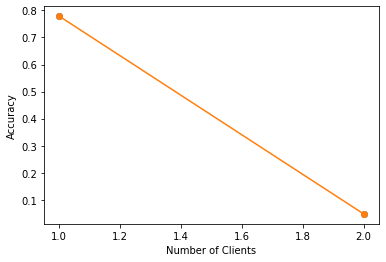

In [31]:
# evaluate different numbers of ensembles on hold out set
print(n_clients)
final_train_X, final_train_y, final_test_X, final_test_y = load_clean_dataset('all_data_' + str(n_clients) + '_' + TESTING_DATA + '_keep_0_train_9.json')
single_scores, ensemble_scores = list(), list()
for i in range(1, n_clients+1):
	ensemble_score = evaluate_n_members(members, i, x_test, y_test)
	_, single_score = members[i-1].evaluate(x_test, y_test, verbose=0)
	print('> %d: single=%.5f, ensemble=%.5f' % (i, single_score, ensemble_score))
	ensemble_scores.append(ensemble_score)
	single_scores.append(single_score)
# plot score vs number of ensemble members
print('Accuracy %.5f (%.5f)' % (mean(single_scores), std(single_scores)))
x_axis = [i for i in range(1, n_clients+1)]
pyplot.xlabel('Number of Clients')
pyplot.ylabel('Accuracy')
pyplot.plot(x_axis, single_scores, marker='o', linestyle='None', label='Accuracy')
pyplot.plot(x_axis, ensemble_scores, marker='o')
pyplot.savefig('statistic_' + str(n_clients) + '_' + str(n_infected_clients) + '.png')
print(n_infected_clients)
pyplot.show()